# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    N = np.int(np.ceil(3*sigma))
    x = y = np.linspace(np.int(-3*sigma),np.int(3*sigma),2*N+1)
    X,Y = np.meshgrid(x,y)
    noyau = np.exp(-(X*X+Y*Y)/(2*sigma*sigma))
    return noyau/noyau.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    Ix=scipy.signal.convolve2d(image,Sx,mode='same')
    Iy=scipy.signal.convolve2d(image,Sy,mode='same')
    
    Ix2=Ix**2
    Iy2=Iy**2
    Ixy=Ix*Iy
    Gkernel=gaussianKernel(scale)  #filtre gaussien
    
    #Calcul des convolutions
    gIx2=scipy.signal.convolve2d(Ix2,Gkernel,mode='same')
    gIy2=scipy.signal.convolve2d(Iy2,Gkernel,mode='same')
    gIxy=scipy.signal.convolve2d(Ixy,Gkernel,mode='same')
    
    det=gIx2*gIy2-gIxy**2
    trace=gIx2+gIy2
    
    R=det-kappa*(trace**2)
    
    return R
    
    
    
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

Image house2.png


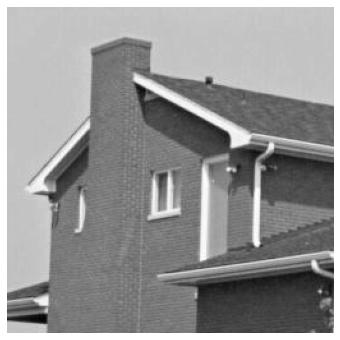

La réponse d'Harris pour l'image house2.png, avec une filtre gaussien de taille 15


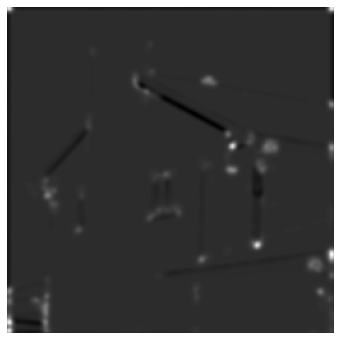

In [3]:
image=np.array(Image.open("img/house2.png"))
print("Image house2.png")
imshow(image)

print("La réponse d'Harris pour l'image house2.png, avec une filtre gaussien de taille 15")
W=15
sigma=(W-1)/6
R=computeR(image,sigma,0.04)
imshow(R)


3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

- La réponse de Harris montre bien les contours ,les coins et les régions sur l'image.
* R>0 : représente un coin
* R=0 : représente un région
* R<0 : représente un contours

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [200]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R<thres,0,1)
    

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [203]:
def Rnms(image_harris,Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    R=image_harris.copy()
    
    n=R.shape[0]
    m=R.shape[1]
    Rlocmax=np.zeros((n,m))
    List=[]
    
    for i in range(1,n-1):
        for j in range(1,m-1):
            Liste=[]
            liste=np.matrix.tolist((R[i-1:i+2,j-1:j+2]).reshape((1,9)))
            liste=liste[0]
            del liste[4]
            if np.all(R[i,j]>liste) and Rbin[i,j]==1:
                Rlocmax[i,j]=1
    
    return Rlocmax
            
            
    
    

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [204]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R=computeR(image,sigma,kappa)
    Rbin=thresholdR(R,thres)
    Rlocmax=Rnms(R,Rbin)
    return Rlocmax
    

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

Image house2.png :



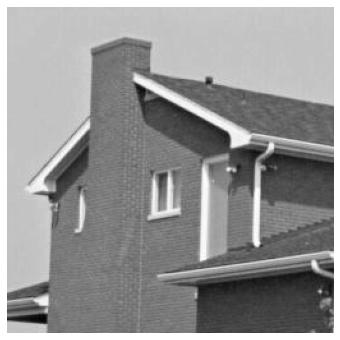

Detection de coins dans l'image house2.png :



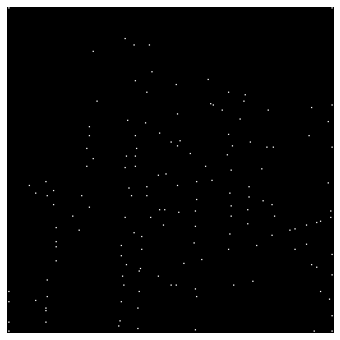

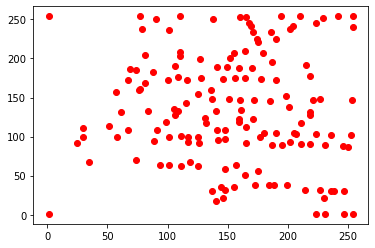

In [211]:
image=np.array(Image.open("img/house2.png"))
print("Image house2.png :\n")
imshow(image)

print("Detection de coins dans l'image house2.png :\n")
W=15
sigma=(W-1)/6
kappa=0.04
thres=900000
Result=cornerDetector(image,sigma,kappa,thres)
imshow(Result)
plt.scatter(np.nonzero(Result)[0],np.nonzero(Result)[1],c='red')

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

The performance of the corner detector :

Le detecteur de coin permet de detecter les coin grace à la réponse du détecteur de Harris.

Sigma=14/6=2,33
Threshold=900000


## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

Image house2.png :



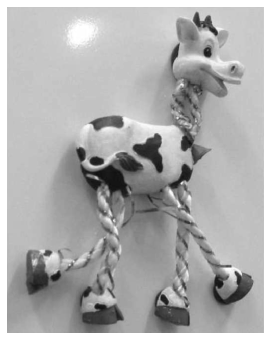

Detection de coins dans l'image toyHorse1.png :

Image house2.png :



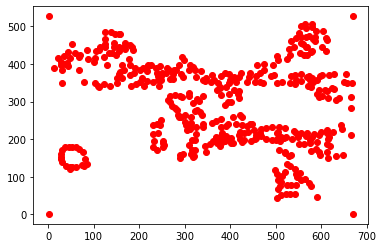

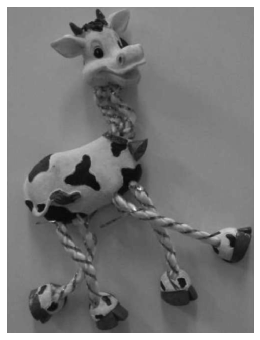

Detection de coins dans l'image toyHorse2.png :



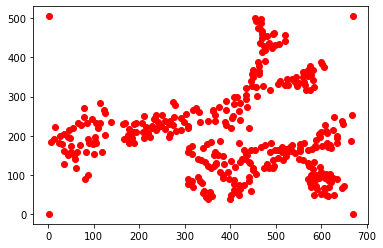

In [206]:
image1=np.array(Image.open("img/toyHorse1.png"))
print("Image house2.png :\n")
imshow(image1)

W=15
sigma=(W-1)/6
kappa=0.04
thres=1000000

print("Detection de coins dans l'image toyHorse1.png :\n")
Result=cornerDetector(image1,sigma,kappa,thres)
plt.scatter(np.nonzero(Result)[0],np.nonzero(Result)[1],c='red')


image2=np.array(Image.open("img/toyHorse2.png"))
print("Image house2.png :\n")
imshow(image2)

print("Detection de coins dans l'image toyHorse2.png :\n")
Result=cornerDetector(image2,sigma,kappa,thres)
plt.scatter(np.nonzero(Result)[0],np.nonzero(Result)[1],c='red')

2) What are the dynamic ranges of these two images ?

In [207]:
Max=image1.max()
Min=image1.min()
L=Max-Min+1
print("Dynamic range of image toyHorse1 :",L)

Max=image2.max()
Min=image2.min()
L=Max-Min+1
print("Dynamic range of image toyHorse2 :",L)


Dynamic range of image toyHorse1 : 255
Dynamic range of image toyHorse2 : 254


3) What are the transformations beetween the two images ?

l'image2 est une rotation de l'image1
l'image2 à un contrast plus elevé que l'image1

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Oui, La detection de coins est invariante à la rotation, car les valeurs propres qui servent au calcul de la réponse du détecteur de Harris sont pareilles.
Oui, La detection de coins est invariante à au changement de contraste car les max locaux sont les memes pour les 2 images.